Classification of the financial tweets using BERT and LTSM.
https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment - source of the dataset.

## Import Libraries

In [1]:
# install if needed, datasets library by default is not installed in Colab
!pip install datasets

# import PyTorch to work with deep learning models
import torch
from torch import nn, optim

# import PyTorch data loader to work with datasets
from torch.utils.data import DataLoader, random_split

# import BERT model and tokeniser from transformers library
# transformers library allows to work with language models hosted by Hugging Face
from transformers import BertTokenizer, BertModel, AdamW

# dataset library allows to work with dataset hosted by Hugging Face
from datasets import load_dataset

# metrics for models' evaluation and visualisation
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# to work with data
import pandas as pd
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load and Prepare data

In [ ]:
# loading and preprocessing of the dataset
def load_dataset_finance(tokenizer, include_bert=False):
    # load dataset from Hugging Face, load both train and validation parts
    dataset = load_dataset("zeroshot/twitter-financial-news-sentiment", split={'train': 'train', 'validation': 'validation'})

    # tokenise items, may be updated to larger number to reflect Tweets lenghth
    # 128 was choosen for models speed of training
    def tokenise_function(item):
        return tokenizer(item['text'], padding="max_length", truncation=True, max_length=128)

    dataset = dataset.map(tokenise_function, batched=True)

    # convert labels to work with PyTorch
    def transform_labels(batch):
        batch['labels'] = torch.tensor(batch['label'], dtype=torch.long)
        return batch

    dataset = dataset.map(transform_labels)

    # BERT model require attention mask
    if include_bert:
        dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    else:
        dataset.set_format(type='torch', columns=['input_ids', 'labels'])

    return dataset

# create testing, validation, and training data loaders based on the dataset
def create_data_loaders(dataset, batch_size=16, include_bert=False):

    def collate_items(batch):
        input_ids_list = [item['input_ids'].squeeze() for item in batch]
        labels_list = [item['labels'] for item in batch]
        if include_bert:
            attention_mask_list = [item['attention_mask'].squeeze() for item in batch]
            return {'input_ids': torch.stack(input_ids_list), 'attention_mask': torch.stack(attention_mask_list), 'labels': torch.stack(labels_list)}
        else:
            return {'input_ids': torch.stack(input_ids_list), 'labels': torch.stack(labels_list)}

    # split validation dataset 40/60 - 40% for validation and 60% for testing
    validation_size = int(0.4 * len(dataset['validation']))
    test_size = len(dataset['validation']) - validation_size
    valid_dataset, test_dataset = random_split(dataset['validation'], [validation_size, test_size])

    train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_items)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_items)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_items)

    # return the DataLoaders for training, validation, and testing
    return train_loader, valid_loader, test_loader

## Explore and Visualise Data


Example of the training data:
                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0

Example of the validation data:
                                                text  label
0  $ALLY - Ally Financial pulls outlook https://t...      0
1  $DELL $HPE - Dell, HPE targets trimmed on comp...      0
2  $PRTY - Moody's turns negative on Party City h...      0
3                   $SAN: Deutsche Bank cuts to Hold      0
4                  $SITC: Compass Point cuts to Sell      0





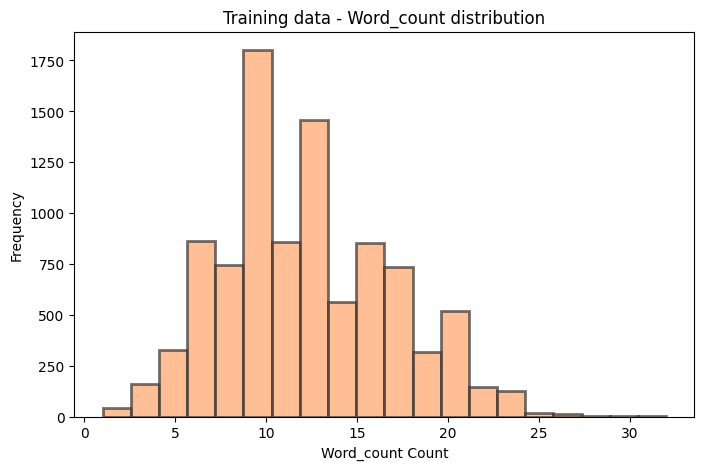

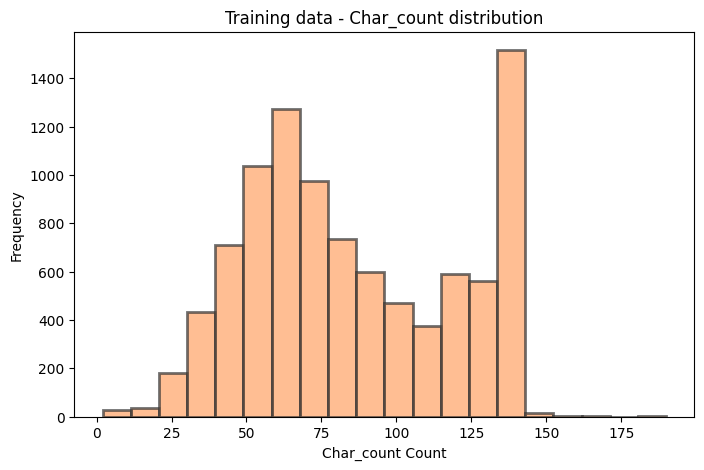

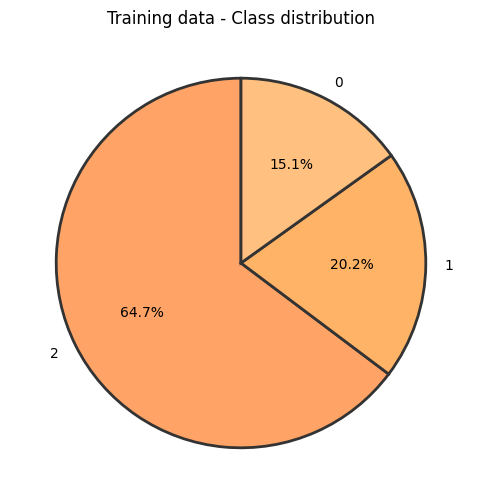


Class distribution in Training data:
 label
2    64.738552
1    20.150896
0    15.110552
Name: proportion, dtype: float64


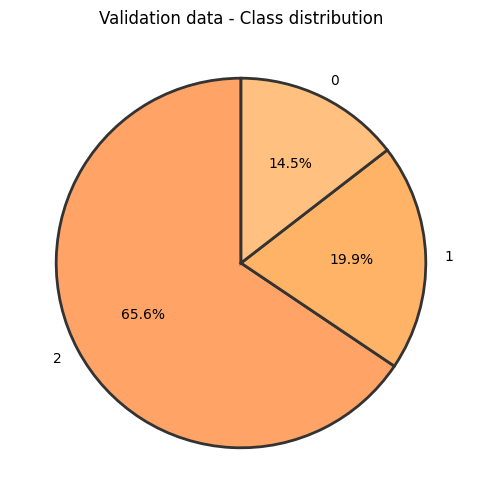


Class distribution in Validation data:
 label
2    65.577889
1    19.891122
0    14.530988
Name: proportion, dtype: float64

Outliers in word_count:
                                                   text  word_count
342   Upgrades 11/25: $ARWR $CACI $CF $DECK $DKS $EN...          25
606   It may seem odd for the Federal Reserve to buy...          25
1158  $TCCO insane, halted again...... Just 1.85M sh...          26
1230  Amazon Announces First-Ever ‘Amazon Future Eng...          26
1455  Executives at SoftBank are looking for a way t...          25
3609  Penn National Gaming Reports Fourth Quarter Re...          26
4077  A Tokióban található teamLab Planets, a múzeum...          27
4133  Are trade wars good and easy to win? We try to...          25
4152  At dinner, man in a wheelchair had to be over ...          26
4368  Dear Moneyist,\nI don't want to be a money gra...          25
4438  Expert: ‘there are people at the top who are m...          27
4503  Given 6 months to live, woma

In [3]:
# load data for exploration
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment", split={'train': 'train', 'validation': 'validation'})
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])

print("Example of the training data:")
print(train_df.head())
print("\nExample of the validation data:")
print(validation_df.head())

# add word and char count columns to the traininig data
train_df['word_count'] = train_df['text'].str.split().apply(len)
train_df['char_count'] = train_df['text'].apply(len)

def plot_length_histogram(df, column, title):
    plt.figure(figsize=(8, 5))
    patches = plt.hist(
        df[column], bins=20, alpha=0.7, color='#FFA366', edgecolor='#333', linewidth=2
    )[2]

    # style histogram
    for patch in patches:
        patch.set_edgecolor('#333')
        patch.set_linewidth(2)

    plt.title(f"{title} - {column.capitalize()} distribution")
    plt.xlabel(f"{column.capitalize()} Count")
    plt.ylabel("Frequency")
    plt.show()

print("\n\n")
plot_length_histogram(train_df, 'word_count', "Training data")
print("\n\n")
plot_length_histogram(train_df, 'char_count', "Training data")
print("\n\n")

# plot classes distribution in the data as a pie chart
def plot_class_distribution(df, title):
    label_counts = df['label'].value_counts(normalize=True) * 100
    plt.figure(figsize=(6, 6))
    class_names = label_counts.index

    plt.pie(
        label_counts,
        labels = class_names,
        autopct = '%1.1f%%',
        colors = ['#FFA366', '#FFB366', '#FFC080', '#FFD4A1'] ,
        startangle=90,
        wedgeprops={'edgecolor': '#333', 'linewidth': 2}
    )

    plt.title(f"{title} - Class distribution")
    plt.show()
    print(f"\nClass distribution in {title}:\n", label_counts)

plot_class_distribution(train_df, "Training data")
plot_class_distribution(validation_df, "Validation data")

# detect outliers in data frame columns
def detect_outliers(df, column):
    quart1 = df[column].quantile(0.25)
    quanrt3 = df[column].quantile(0.75)
    iqr = quanrt3 - quart1
    lower_bound = quart1 - 1.5 * iqr
    upper_bound = quanrt3 + 1.5 * iqr

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"\nOutliers in {column}:")
    print(outliers[['text', column]])
    return outliers

# detect outliers by word and char count
word_outliers = detect_outliers(train_df, 'word_count')
print("\n\n")
char_outliers = detect_outliers(train_df, 'char_count')

# visualise shortest and longest tweets
def display_outliers(df, column, n=5):
    print(f"\nShortest {n} tweets by {column}:")
    print(df.nsmallest(n, column)[['text', column]])

    print(f"\nLongest {n} tweets {column}:")
    print(df.nlargest(n, column)[['text', column]])

display_outliers(train_df, 'word_count')
print("\n\n")
display_outliers(train_df, 'char_count')

## Implement Models

In [ ]:
# LSTM classifier
class LSTMClassifier(nn.Module):
    # initialise model architecture
    def __init__(self, in_dim, hid_dim, out_dim, n_layers, bi, drop):
        super().__init__()
        # embedding of the input
        self.embedding = nn.Embedding(in_dim, hid_dim)
        self.lstm = nn.LSTM(hid_dim, hid_dim, num_layers=n_layers, bidirectional=bi, dropout=drop, batch_first=True)

        # *2 because we use bidirectional LSTM
        self.fc = nn.Linear(hid_dim * 2, out_dim)
        self.dropout = nn.Dropout(drop)

    # forward pass of the model
    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        output, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        output = self.fc(self.dropout(hidden))
        return output

# Classifier based on BERT transformer
class BertClassifier(nn.Module):
    def __init__(self, bert_m, output_dim):
        super().__init__()
        self.bert = bert_m
        self.fc = nn.Linear(bert_m.config.hidden_size, output_dim)

    # forward pass of the network
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.fc(pooled_output)

## Training Models


In [ ]:
# training loop
def train(model, train_loader, optimiser, model_type):
    device = torch.device('cuda')
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    calc_loss = 0

    for batch in train_loader:
        optimiser.zero_grad()
        if model_type in ['bert', 'bert_lstm']:
            predictions = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
        else:
            predictions = model(batch['input_ids'].to(device))
        loss = loss_fn(predictions, batch['labels'].to(device))
        loss.backward()
        optimiser.step()
        calc_loss += loss.item()
    return calc_loss / len(train_loader)

# model evaluation
def evaluate(model, eval_loader, model_type):
    model.eval()
    calc_loss = 0
    all_preds = []
    all_labels = []
    device = torch.device('cuda')
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in eval_loader:
            targets = batch['labels'].to(device)
            if model_type in ['bert', 'bert_lstm']:
                predictions = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
            else:
                predictions = model(batch['input_ids'].to(device))

            loss = loss_fn(predictions, batch['labels'].to(device))
            calc_loss += loss.item()
            preds = predictions.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # use macro because multiclass problem - 3 classes
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    return calc_loss / len(eval_loader), precision, recall, f1, accuracy, all_labels, all_preds

# main function for the training
def main(model_type='lstm', num_epochs = 5):
    # load tokeniser from Hugging Face as it is used for all three models
    tokeniser = BertTokenizer.from_pretrained('bert-base-uncased')

    include_bert = model_type in ['bert', 'bert_lstm']

    dataset = load_dataset_finance(tokeniser, include_bert=include_bert)
    train_loader, valid_loader, test_loader = create_data_loaders(dataset, include_bert=include_bert)

    if model_type == 'lstm':
        # 3 output classes, 2 lstm layers, bidirectional with dropout 0.5
        model = LSTMClassifier(tokeniser.vocab_size, 262, 3, 2, True, 0.5)
    elif model_type == 'bert':
        bert_model = BertModel.from_pretrained('bert-base-uncased')
        model = BertClassifier(bert_model, 3)
    elif model_type == 'bert_lstm':
        bert_model = BertModel.from_pretrained('bert-base-uncased')
        # 3 output classes, 4 lstm layers, bidirectional with dropout 0.5
        model = BertLSTMClassifier(bert_model, 262, 3, 4, True, 0.5)

    # smaller learning rate for transformer-only model
    optimizer = AdamW(model.parameters(), lr=2e-5 if model_type == 'bert' else 2e-4)
    model.to(torch.device('cuda'))

    # training loop
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, model_type)
        valid_loss, precision, recall, f1, accuracy, _, _ = evaluate(model, valid_loader, model_type)
        print(f'Epoch {epoch+1}: Trainining loss={train_loss}, Validation loss={valid_loss}, '
              f'Precision={precision}, Recall={recall}, F1={f1}, Accuracy={accuracy}')

    # return trained model and data for testing
    return model, test_loader


## Testing Models

In [ ]:
def test(model, test_loader, model_type):
    # get metrics from model evaluation
    test_loss, precision, recall, f1, accuracy, all_targets, predictions = evaluate(model, test_loader, model_type)
    total_samples = len(all_targets)
    correctly_classified = np.sum(np.array(predictions) == np.array(all_targets))
    incorrectly_classified = total_samples - correctly_classified

    print(f'Testing loss: {test_loss}, Precision: {precision}, Recall: {recall}, F1: {f1:}, Accuracy: {accuracy}')
    print(f'Total samples: {total_samples}, Correctly classified: {correctly_classified}, Incorrectly classified: {incorrectly_classified}')

    # calculate and visualise confusion matrix
    cm = confusion_matrix(all_targets, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Oranges')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

### Testing LSTM model

In [ ]:
lstm_model, lstm_test_loader = main('lstm')

Epoch 1: Trainining loss=0.7755592381035663, Validation loss=0.6673815379540126, Precision=0.6267014701126892, Recall=0.5683762281929822, F1=0.5789754787615918, Accuracy=0.7371727748691099
Epoch 2: Trainining loss=0.5719202926859783, Validation loss=0.5842692059775193, Precision=0.7301687151303055, Recall=0.6776217165615072, F1=0.6992177889327383, Accuracy=0.7947643979057591
Epoch 3: Trainining loss=0.43439230471662243, Validation loss=0.5676779379447301, Precision=0.7368410946721643, Recall=0.6780349231919912, F1=0.6990239566501493, Accuracy=0.7958115183246073
Epoch 4: Trainining loss=0.31551000078706387, Validation loss=0.6111822163065275, Precision=0.7122626548369122, Recall=0.7237325719655563, F1=0.7174854819976771, Accuracy=0.7916230366492146
Epoch 5: Trainining loss=0.22201578036711944, Validation loss=0.6566794070104758, Precision=0.7414222720001966, Recall=0.6859733489314642, F1=0.7073358785535907, Accuracy=0.8010471204188482


Testing loss: 0.6365360381702582, Precision: 0.7426500535079618, Recall: 0.6875749300772996, F1: 0.7106413441114813, Accuracy: 0.8053035589672016
Total samples: 1433, Correctly classified: 1154, Incorrectly classified: 279


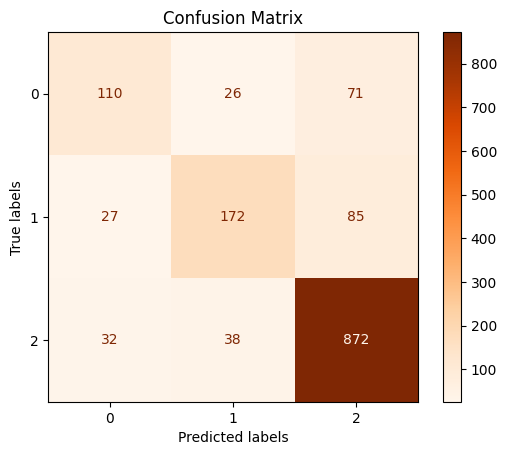

In [ ]:
test(lstm_model, lstm_test_loader, 'lstm')

### Testing BERT model

In [ ]:
bert_model, bert_test_loader = main(model_type='bert', num_epochs = 2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Trainining loss=0.5381538229471874, Validation loss=0.3655185957749685, Precision=0.7914022105101629, Recall=0.8541600681990689, F1=0.817706273205503, Accuracy=0.8554973821989529
Epoch 2: Trainining loss=0.26663834284959825, Validation loss=0.2980301672592759, Precision=0.8642596724566651, Recall=0.8594704444099577, F1=0.8606172868219363, Accuracy=0.8879581151832461


Testing loss: 0.33208131247924433, Precision: 0.8481889725587205, Recall: 0.842670037490776, F1: 0.8445105453719535, Accuracy: 0.8806699232379623
Total samples: 1433, Correctly classified: 1262, Incorrectly classified: 171


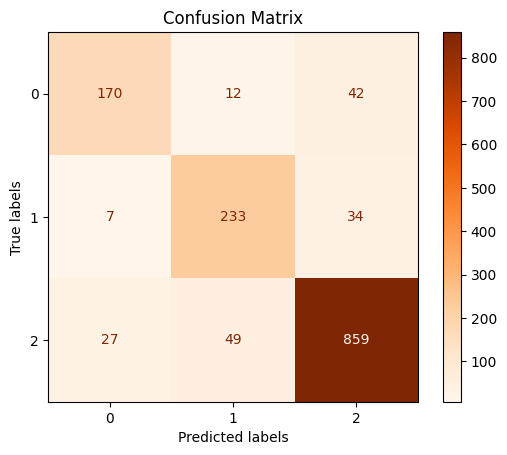

In [ ]:
test(bert_model, bert_test_loader, 'bert')